In [133]:
import pandas as pd
import datetime as dt
import pickle
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split,ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
plt.figure(figsize=(20,10))
import os
os.chdir("E:\\Lam\\SheetMetal_Newdata\\data")

In [134]:
data = pd.read_csv("sm_trial_working_Now.csv")
data.columns

C:\Users\Admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (8,9,10,54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['id', 'ERF_No', 'ERF_Line', 'ERF_ID', 'ERF_Type', 'ERF_Status',
       'ENG_Purpose', 'Part_Number', 'Part_Number_1', 'Part_Number_2',
       'Part_Number_3', 'Rev', 'MatGroup', 'MatStatus', 'PO_Desc', 'ERF_Cost',
       'Item_Qty', 'PO_Price', 'Internal_Order', 'Cost_Center',
       'ERF_Submit_Date', 'ERF_Approved_DateTime', 'ERF_Approved_Date',
       'PO_Create_Date', 'Prom_Date', 'ERF_END_Date', 'Rct_Date',
       'Days_Frcst_cal', 'Days_End_cal', 'Days_END', 'Days_Prom_cal',
       'Days_Prom', 'prom_po_diff_created', 'Del_PO_Diff', 'Due_Date',
       'Supplier_Code', 'Supplier_Name', 'Primary_Commodity', 'ERF_Requestor',
       'Program_Manager', 'SMG', 'SMG_Group', 'SBM', 'SE', 'RPM_Supplier_list',
       'Distribution_Supplier', 'Buyer_Code', 'Buyer_Name', 'Prod_Grp',
       'Deletion_Ind', 'Plant', 'PO', 'PO_Line', 'POLI', 'Matl_Doc', 'PO_Text',
       'Rct_Week', 'First_Rct', 'First_Buy_Date', 'Repeat_Buy',
       'PR_Submit_Date', 'PR_Complete_Date', 'PR_OrdFull', 'P

In [135]:
cols_to_del = ['PO_Line','ERF_Line','ERF_Status','Prom_Date','Due_Date','Rct_Date',
              'Days_End_cal', 'Days_Prom_cal','Delivered_Lead_Time','Requested_Intensity_ext_qty1',
               'Prom_End_diff_Calc','PO_Price','Item_Qty'
               'prom_po_diff_created','ERF_Submit_Month','ERF_Submit_Year','Days_Frcst','Lead_Time','Fees','Approval_TAT','PO.1',]

date_cols = ['ERF_Submit_Date','ERF_Approved_DateTime','ERF_Approved_Date','PO_Create_Date','Prom_Date','ERF_END_Date',
             'Due_Date','Rct_Date','First_Buy_Date']


In [136]:
for col in date_cols:
    data[col] = pd.to_datetime(data[col])

In [137]:
part_num_2_data = data[['Part_Number_2','EXPEDITE_FEE']].groupby('Part_Number_2').mean().reset_index(None)
part_num_2_data.columns = ['Part_Number_2','Part_2_avg_exp_fee']
data = data.merge(part_num_2_data,how='inner')

In [138]:
data['Requested_Intensity_ext_qty']=data['Ext_Cost']/data['Lead_Time']
data['Requested_Intensity_ext_qty1']=data['Requested_Intensity_ext_qty']/data['PO_Qty']


In [139]:
data.dropna(subset=['First_Buy_Date'],how='any',inplace=True)    ## Removed NAs ##
data.dropna(subset=['PO_Qty'],how='any',inplace=True)
data.dropna(subset=['Requested_Intensity_ext_qty1'],how='any',inplace=True)


In [140]:
data['Lead_Time'] = (data.ERF_END_Date - data.ERF_Submit_Date).dt.days 
data.loc[data.Lead_Time==0,'Lead_Time']=1
data['Promised_Lead_Time'] = (data.Prom_Date - data.ERF_Submit_Date).dt.days
data.loc[data.Promised_Lead_Time==0,'Promised_Lead_Time']=1
data['Promised_Request_Lead_Time'] = (data.Prom_Date - data.ERF_END_Date).dt.days
data.loc[data.Promised_Request_Lead_Time==0,'Promised_Request_Lead_Time']=1
data['Qty_over_Price'] = data.Item_Qty/data.PO_Price
data['Ext_Over_Lead'] = data.Ext_Cost/data.Lead_Time
data['Ext_Over_Prom_Lead'] = data.Ext_Cost/data.Promised_Lead_Time
data['Ext_Over_Prom_Req_Lead'] = data.Ext_Cost/data.Promised_Request_Lead_Time

data['Age'] = (data.ERF_Submit_Date-data.First_Buy_Date).dt.days
data.loc[data.Age<0,'Age'] = 0
data['ERF_Submit_Year'] = data['ERF_Submit_Date'].dt.year
data['ERF_Submit_Qtr'] = data.ERF_Submit_Date.dt.quarter

In [141]:
data_rebuy_yes = data[data.Repeat_Buy == "Yes"]
data_rebuy_No = data[data.Repeat_Buy == "No"]

In [142]:
data_rebuy_yes.sort_values(by="ERF_Submit_Date",inplace=True)
part_numbers_unique = data_rebuy_yes.Part_Number.unique()

data_rebuy_yes['Del_Ind'] = "N"

vars_for_prev = ['EXPEDITE_FEE','PO_Price','PO_Qty','Ext_Cost','Lead_Time','Promised_Lead_Time','Promised_Request_Lead_Time',
                 'Qty_over_Price','Ext_Over_Lead','Ext_Over_Prom_Lead','Ext_Over_Prom_Req_Lead']
prev_vars = ["PREV_"+var for var in vars_for_prev]
for prev_var in prev_vars:
    data_rebuy_yes[prev_var] = "No"

for part_num in part_numbers_unique:
    if len(data_rebuy_No[data_rebuy_No['Part_Number'] == part_num]) ==0:
        data_rebuy_yes.loc[data_rebuy_yes['Part_Number'] == part_num,'Del_Ind'] = "Y"
        
    elif len(data_rebuy_yes.loc[data_rebuy_yes['Part_Number'] == part_num]) > 1 :
        data_temp = data_rebuy_yes[data_rebuy_yes.Part_Number==part_num].sort_values("ERF_Submit_Date")
        
        for i in range(len(prev_vars)):
            var = vars_for_prev[i]
            prev_var = prev_vars[i]
            
            temp1 = data_temp[var].shift()
            data_rebuy_yes.loc[data_rebuy_yes['Part_Number'] == part_num,prev_var] = temp1
            
            temp2 =  data_rebuy_No.loc[data_rebuy_No['Part_Number'] == part_num,var].values[0]
            data_rebuy_yes.loc[(data_rebuy_yes[prev_var].isnull()) & (data_rebuy_yes['Part_Number'] == part_num),prev_var] = temp2
                                                                  
    else:
        for i in range(len(prev_vars)):
            var = vars_for_prev[i]
            prev_var = prev_vars[i]
            
            temp =  data_rebuy_No.loc[data_rebuy_No['Part_Number'] == part_num,var].values[0]
            data_rebuy_yes.loc[data_rebuy_yes['Part_Number'] == part_num,prev_var] = temp

        
data_rebuy_yes_del_Y =  data_rebuy_yes[data_rebuy_yes.Del_Ind=="Y"]
data_rebuy_yes_del_N =  data_rebuy_yes[data_rebuy_yes.Del_Ind=="N"]
data_rebuy_yes.to_csv("data_rebuy_yes.csv",index=False)
data_rebuy_yes_del_Y.to_csv("data_rebuy_yes_del_Y.csv",index=False)
data_rebuy_yes_del_N.to_csv("data_rebuy_yes_del_N.csv",index=False)



In [143]:
data_rebuy = data_rebuy_yes_del_N.copy()
data_rebuy["EXT_Estimate"] = data_rebuy.PREV_PO_Price*data_rebuy.PO_Qty
data_rebuy = data_rebuy[~data_rebuy.MatStatus.isin(['OS','OB','OP'])]


In [146]:
ID_Cols = ['id', 'ERF_No','PO','POLI','Matl_Doc','ERF_ID','Part_Number','Part_Number_1','Part_Number_2','Part_Number_3']
Date_Cols = ['ERF_Submit_Date','ERF_Approved_DateTime','ERF_Approved_Date','PO_Create_Date','Prom_Date','ERF_END_Date',
             'Due_Date','Rct_Date','First_Buy_Date']
ignore_Cols = ['POP_Cycle','ERF_Line','PO_Line','Rev','Repeat_Buy','Prefix_Part_Number''RCT_Week_Calc','Plant','ERF_Status','ERF_Requestor','Buyer_Code','Buyer_Name','Rev_Chg','FA_Rev_Received',
               'ERF_Submit_Month_Calc','ERF_Submit_Year_Calc','MatGroup','Req_Lead_Time_Calc','Delivery_Lead_Time_Calc','Primary_Commodity','Prod_Grp','PO_Text','PN_RevA_Date','Lead_Time','Approval_TAT',
               'Req_Intensity_Qty1_Calc', 'Req_Intensity_ExtQty_Calc','Delivered_Intensity_Calc','Prom_End_diff_Calc','Supplier_Code','SE','Distribution_Supplier','PR_OrdFull','FA_Complete','PO.1','FAIR_No',
               'Del_PO_Diff_Calc','Del_Prom_Diff_Calc', 'RCT_Week_Calc', 'ERF_Submit_Month_Calc','ERF_Submit_Year_Calc','Internal_Order','SBM','Rct_Week','PR_Complete_Date','Order_Intensity','Order_Designation',
               'Days_END','Days_Prom','First_Rct','Repeat_Buy','ERF_Create_Week','Days_Frcst','Ext_Cost','PO_Price','Cost_Center','Program_Manager','PR_Submit_Date','LastRev_Chg','Approval_Weekend',
               'Promised_Lead_Time','Promised_Request_Lead_Time','Qty_over_Price','Ext_Over_Lead','Ext_Over_Prom_Lead','PO_Desc','SMG_Group','SMG','PN_Create_Date','AOPGrp','FA_Insp_Approval_Date',
               'Ext_Over_Prom_Req_Lead','Del_Ind','Prefix_Part_Number','Days_End_cal','Days_Prom_cal','MatStatus','prom_po_diff_created','Days_Frcst_cal','Supplier_Name','SE_Approval_Date','FA_SE','Deletion_Ind']
Target_Col = ['EXPEDITE_FEE']

ignore_Cols.extend(ID_Cols)
ignore_Cols.extend(Date_Cols)
#ignore_Cols.extend(Target_Col)

predictors = [col for col in data_rebuy.columns if col not in ignore_Cols]
cat_features = ['ERF_Type','ENG_Purpose','RPM_Supplier_list','Fees','FAIR','Location','ERF_Submit_Year','ERF_Submit_Qtr']
numeric_features = [col for col in predictors if col not in cat_features]


In [147]:
data_rebuy = pd.get_dummies(data_rebuy,columns=cat_features)
predictors = [col for col in data_rebuy.columns if col not in ignore_Cols]
data_final = data_rebuy[predictors]
data_final = data_final[data_final.EXPEDITE_FEE <=8000]


In [151]:
## Split as Train & Test
X = data_final.drop('EXPEDITE_FEE',1)
y = data_final['EXPEDITE_FEE']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [153]:
def modelfit(alg, X_train, y_train, performCV=True, printFeatureImportance=True, cv_folds=5,save_model=False,
             modelFileName='Final_GBM.sav'):
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='neg_mean_squared_error')
    
    alg.fit(X_train, y_train)
    dtrain_predictions = alg.predict(X_train)
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.sqrt(-np.mean(cv_score)),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(mean_squared_error(y_train.values, dtrain_predictions)))
    
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X_train.columns).sort_values(ascending=False)
        plt.figure(figsize=(20,10))
        feat_imp[:25].plot(kind='barh', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    if save_model:
        filename = modelFileName
        pickle.dump(alg, open(filename, 'wb'))
    return alg, cv_score

def print_test_results(y_test, y_pred):
    print("Correlation = ", np.corrcoef(y_test, y_pred))
    print( "root mean squared error = ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print( "r2 score (coef determination) = ", r2_score(y_pred,y_test))

In [154]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators=50,learning_rate=0.1,max_depth=23,
                                                              min_samples_leaf=50,max_features=20,min_samples_split=5,
                                                              random_state=10,subsample=0.8), 
                        param_grid = param_test5,n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.best_estimator_.score(X_train,y_train)

0.59958476556960705

In [155]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_,gsearch1.best_estimator_

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.45661, std: 0.08836, params: {'subsample': 0.6},
  mean: 0.46537, std: 0.08214, params: {'subsample': 0.7},
  mean: 0.46514, std: 0.08727, params: {'subsample': 0.75},
  mean: 0.46027, std: 0.07441, params: {'subsample': 0.8},
  mean: 0.46125, std: 0.08336, params: {'subsample': 0.85},
  mean: 0.45597, std: 0.08186, params: {'subsample': 0.9}],
 {'subsample': 0.7},
 0.46537311696470007,
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=23, max_features=20,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=50, min_samples_split=5,
              min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
              random_state=10, subsample=0.7, verbose=0, warm_start=False))

In [156]:
import numpy as np

CV Score : Mean - 245.1626 | Std - 22713.72 | Min - -94359.09 | Max - -28500.09

Model Report
RMSE : 183.4
Correlation =  [[ 1.          0.71073244]
 [ 0.71073244  1.        ]]
root mean squared error =  213.996060358
r2 score (coef determination) =  0.505060158493


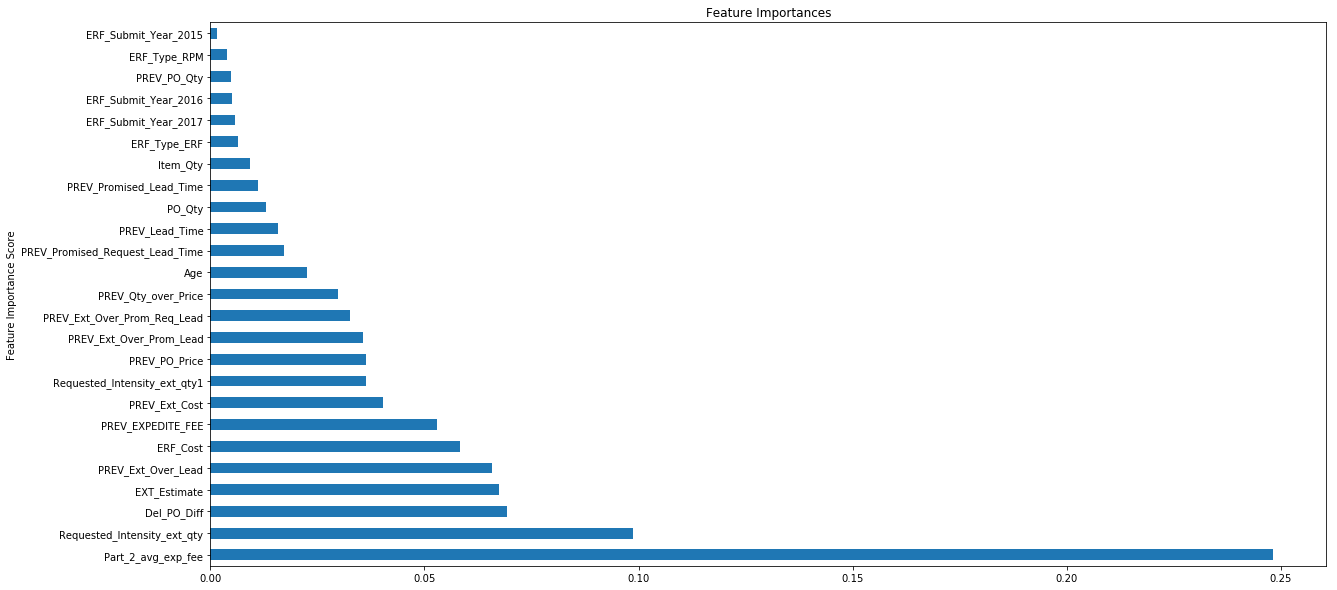

In [157]:
gbm_fee = GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,max_depth=21,
                                        min_samples_leaf=50,max_features=10,subsample=0.8,random_state=10)
clf,cv_score = modelfit(gbm_fee, X_train, y_train ,performCV=True,printFeatureImportance=True,cv_folds=5,
         save_model=True,modelFileName='GBM_Fee_1211.sav')
y_test_pred = gbm_fee.predict(X_test.values)
print_test_results(y_test_pred, y_test.values)

In [158]:
data_test =  data_rebuy[data_rebuy.EXPEDITE_FEE<=8000]
data_test['PREDICTED'] = gbm_fee.predict(data_test[predictors].drop('EXPEDITE_FEE',1))


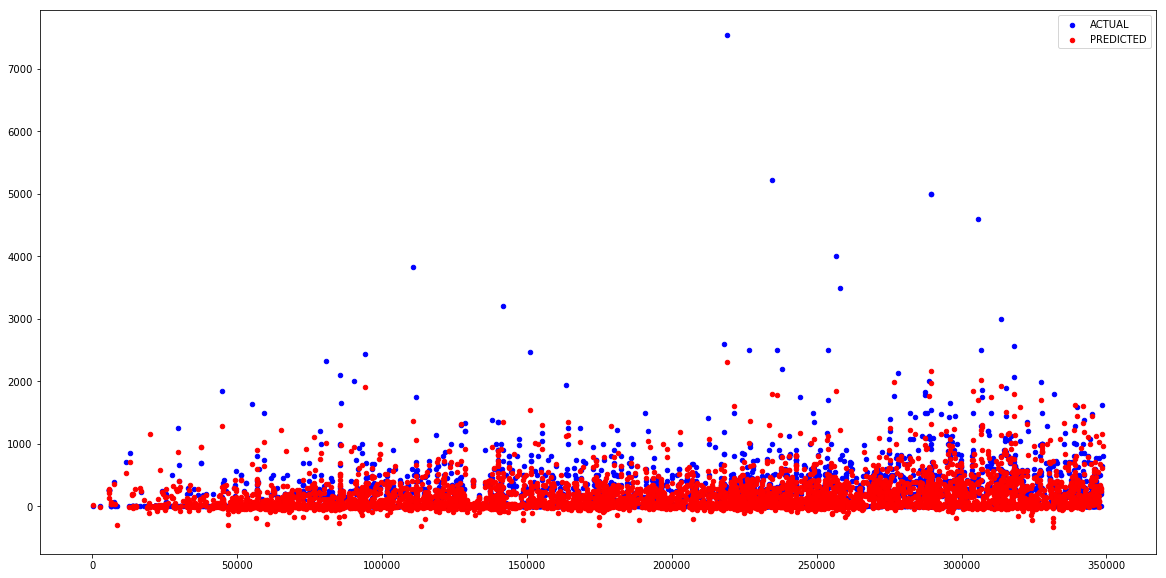

In [159]:
data_temp = data_test[['id','EXPEDITE_FEE','PREDICTED']]
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)

ax1.scatter(data_temp['id'], data_temp['EXPEDITE_FEE'], s=20, c='b', marker="o", label='ACTUAL')
ax1.scatter(data_temp['id'], data_temp['PREDICTED'], s=20, c='r', marker="o", label='PREDICTED')
plt.legend(loc='upper right');
plt.show()

In [161]:
testData = pd.DataFrame(y_test_pred,y_test.values).reset_index(None)
testData.columns = ['actual','predicted']
testData.sort_values('actual',ascending=False).head(10)

,actual,predicted
882,4600,1706.506033
200,3832,1372.173985
613,2600,659.017031
274,2100,1300.747948
871,1827,533.902564
106,1800,386.048725
449,1750,1179.661673
1235,1650,752.870869
623,1346,529.855652
25,1250,1033.921391


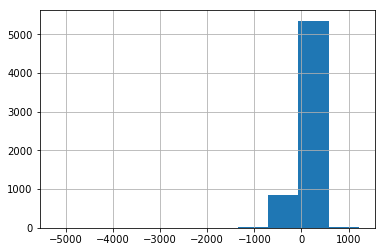

In [163]:
data_temp = data_test[['id','EXPEDITE_FEE','PREDICTED']]
data_final['PREDICTED'] = gbm_fee.predict(data_final.drop('EXPEDITE_FEE',1))
data_final.loc[data_final.PREDICTED <=0,'PREDICTED'] = 0
data_final['Error'] = data_final['PREDICTED'] - data_final['EXPEDITE_FEE']
data_final.Error.hist()

In [164]:
y_train_error = y_train - gbm_fee.predict(X_train.values)
X_train['PREDICTED'] = gbm_fee.predict(X_train.values)

y_test_error = y_test - gbm_fee.predict(X_test.values)
X_test['PREDICTED'] = gbm_fee.predict(X_test.values)


CV Score : Mean - 187.9362 | Std - 14333.29 | Min - -57772.47 | Max - -13895.63

Model Report
RMSE : 102.5
Correlation =  [[ 1.          0.09885683]
 [ 0.09885683  1.        ]]
root mean squared error =  218.422685089
r2 score (coef determination) =  -0.0418714429476


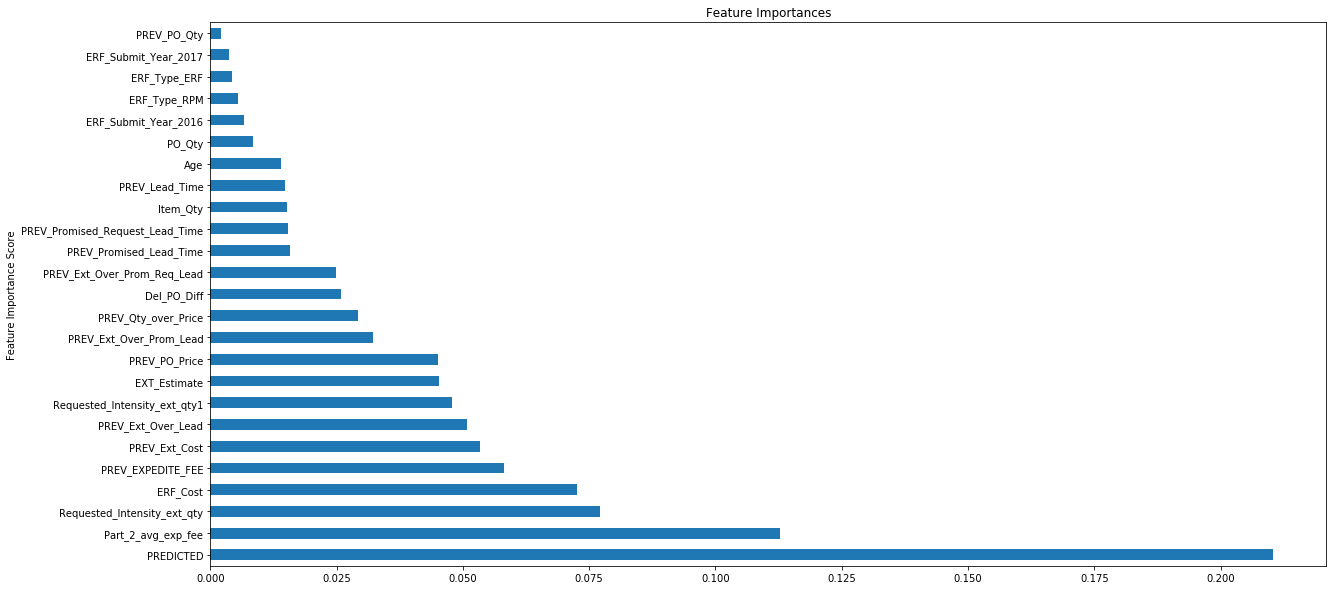

In [165]:
gbm_error = GradientBoostingRegressor(n_estimators=300,learning_rate=0.1,max_depth=21,
                                        min_samples_leaf=50,max_features=10,subsample=0.8,random_state=10)
clf,cv_score = modelfit(gbm_error, X_train, y_train_error ,performCV=True,printFeatureImportance=True,cv_folds=5,
         save_model=True,modelFileName='GBM_Error_1112.sav')
y_test_pred = gbm_error.predict(X_test.values)
print_test_results(y_test_pred, y_test_error.values)

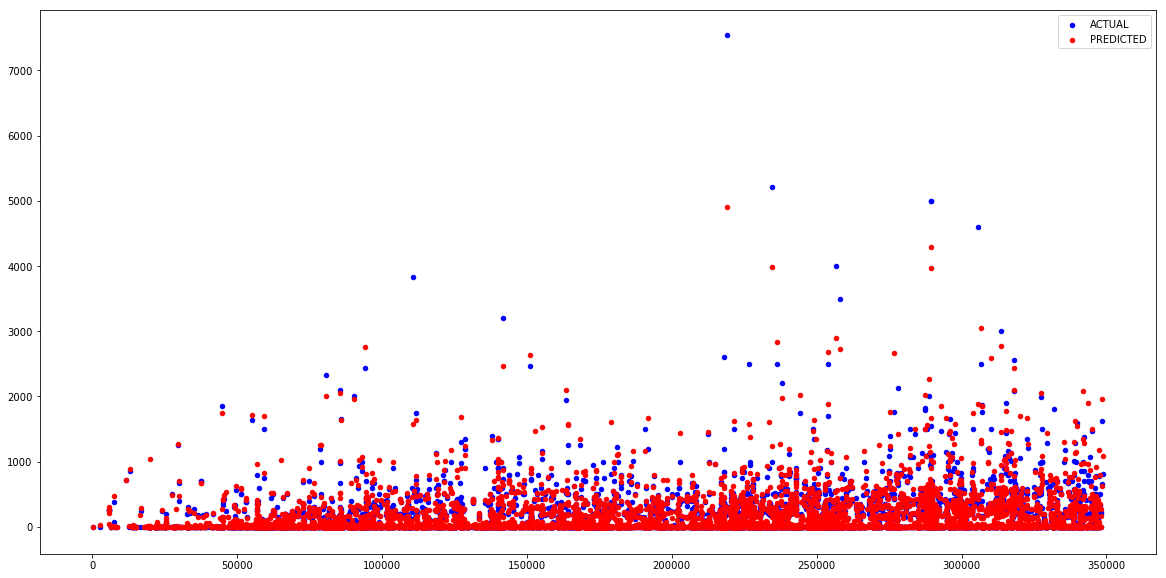

In [186]:
predictors.append('PREDICTED')
gbm_error.predict(data_test[predictors].drop('EXPEDITE_FEE',1))
data_test['PREDICTED_ERROR'] = gbm_error.predict(data_test[predictors].drop('EXPEDITE_FEE',1))
data_test['Final_Predicted_Expedite_Fee'] = data_test['PREDICTED'] + 1.5*data_test['PREDICTED_ERROR']
data_test.loc[data_test.Final_Predicted_Expedite_Fee<0,'Final_Predicted_Expedite_Fee'] = 0
data_temp = data_test[['id','EXPEDITE_FEE','Final_Predicted_Expedite_Fee']]


fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.scatter(data_temp['id'], data_temp['EXPEDITE_FEE'], s=20, c='b', marker="o", label='ACTUAL')
ax1.scatter(data_temp['id'], data_temp['Final_Predicted_Expedite_Fee'], s=20, c='r', marker="o", label='PREDICTED')
plt.legend(loc='upper right');
plt.show()

In [188]:
z  = X_test['PREDICTED'] + gbm_error.predict(X_test.values)
testData = pd.DataFrame(y_test.values,z)
testData.rename(columns={0:'ACTUAL','PREDICTED':'PREDICTED'},inplace=True)

In [223]:
testData.head()

,ACTUAL
PREDICTED,
43.762460,300
65.097092,0
205.933732,374
84.303235,783
125.492058,400


In [225]:
data_temp.sort_values(by="EXPEDITE_FEE",ascending=False)
np.sqrt(np.mean((data_temp.EXPEDITE_FEE - data_temp.Final_Predicted_Expedite_Fee)**2))

127.54071473447026

In [226]:
data_test.to_csv("SM_Final_Predicted.csv",index=False)

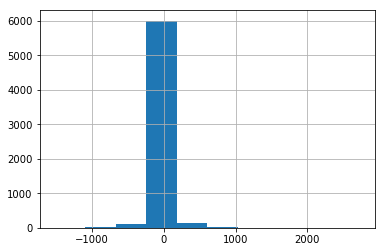

In [227]:
(data_temp.EXPEDITE_FEE - data_temp.Final_Predicted_Expedite_Fee).hist()